In [1]:
import glob
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

def create_model(base_model, classData):
    for layer in base_model.layers:
        layer.trainable = False
            
    top_model = base_model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    
    output_layer = Dense(classData, activation='softmax')(top_model)

    model = Model(inputs=base_model.input, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])        
            
    return model


train_path = 'aug_undersampling_dataset/train'
test_path  = 'aug_undersampling_dataset/test'
IMG_SHAPE = (224, 224, 3)
batch_size = 32
classData = 10

base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model = create_model(base_model, classData)
# model.summary()

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(224,224),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=batch_size
)

Found 3030 files belonging to 10 classes.
Using 2727 files for training.
Found 3030 files belonging to 10 classes.
Using 303 files for validation.


In [3]:
#custom callback
#checkpoint = ModelCheckpoint("rcnnplatemodel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
86/86 [==============================] - 224s 2s/step - loss: 1.5083 - accuracy: 0.5471 - val_loss: 0.7860 - val_accuracy: 0.7888
Epoch 2/10
86/86 [==============================] - 190s 2s/step - loss: 0.4203 - accuracy: 0.8621 - val_loss: 0.5961 - val_accuracy: 0.8284
Epoch 3/10
86/86 [==============================] - 191s 2s/step - loss: 0.1850 - accuracy: 0.9461 - val_loss: 0.5883 - val_accuracy: 0.8482
Epoch 4/10
86/86 [==============================] - 190s 2s/step - loss: 0.1245 - accuracy: 0.9652 - val_loss: 0.5378 - val_accuracy: 0.8548
Epoch 5/10
86/86 [==============================] - 190s 2s/step - loss: 0.0579 - accuracy: 0.9842 - val_loss: 0.6249 - val_accuracy: 0.8251
Epoch 6/10
86/86 [==============================] - 190s 2s/step - loss: 0.0671 - accuracy: 0.9780 - val_loss: 0.7541 - val_accuracy: 0.8482
Epoch 7/10
86/86 [==============================] - 190s 2s/step - loss: 0.0592 - accuracy: 0.9846 - val_loss: 0.6463 - val_accuracy: 0.8416


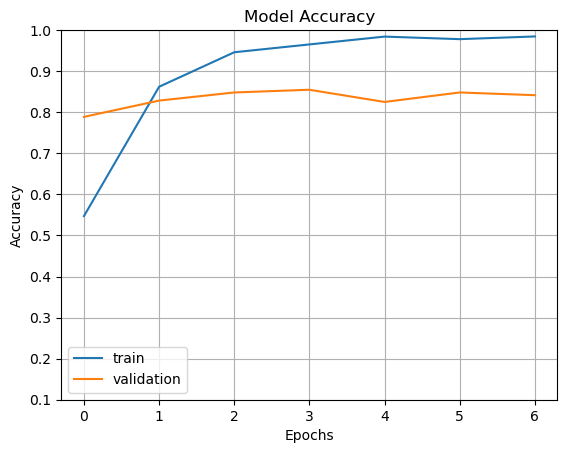

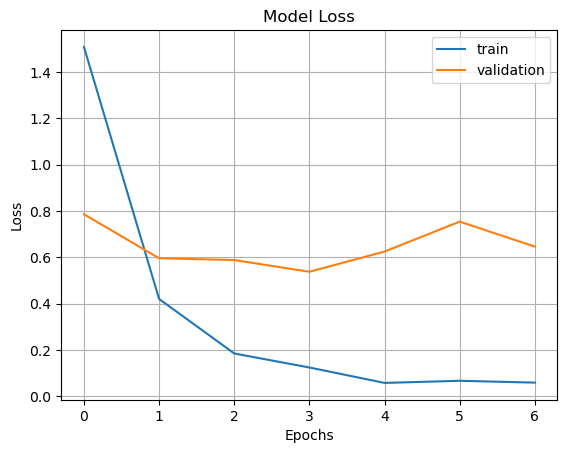

In [4]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=1
)

predictions = model.predict(test_ds)

Found 340 files belonging to 10 classes.
340/340 [==============================] - 40s 109ms/step


In [6]:
import numpy as np
from sklearn.metrics import classification_report

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names))

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.83      0.88      0.86        34
   bacterial_leaf_streak       1.00      0.91      0.95        34
bacterial_panicle_blight       1.00      0.97      0.99        34
                   blast       0.75      0.71      0.73        34
              brown_spot       0.74      0.85      0.79        34
              dead_heart       0.94      0.97      0.96        34
            downy_mildew       0.76      0.76      0.76        34
                   hispa       0.72      0.62      0.67        34
                  normal       0.86      0.88      0.87        34
                  tungro       0.81      0.85      0.83        34

                accuracy                           0.84       340
               macro avg       0.84      0.84      0.84       340
            weighted avg       0.84      0.84      0.84       340



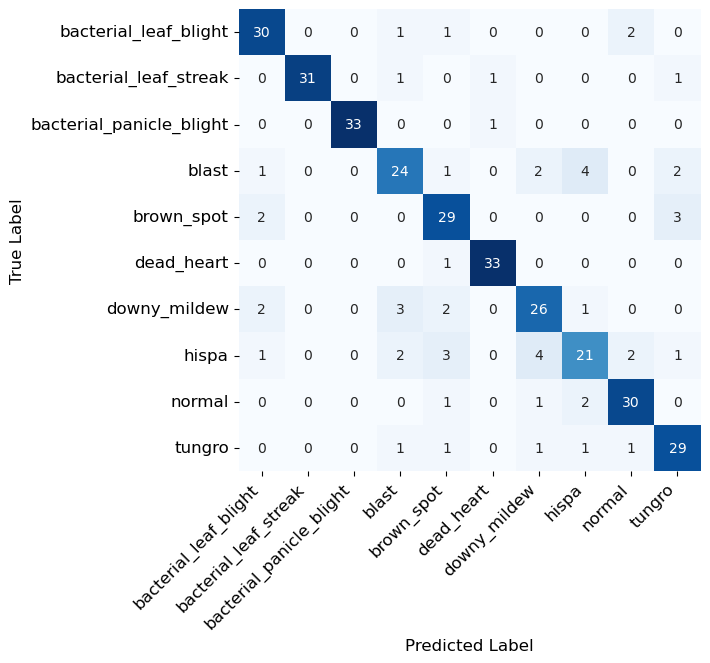

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="EfficientNetV2B0-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [9]:
model.save('EfficientNetV2B0/PaddyDisease_EfficientNetV2B0_UnderSampling_224.h5')

In [8]:
model.save_weights("EfficientNetV2B0/PaddyDisease_EfficientNetV2B0_UnderSampling_224.h5")